# Deep Learning with PyTorch

Classical machine learning relies on using statistics to determine relationships between features and labels, and can be very effective for creating predictive models. However, a massive growth in the availability of data coupled with advances in the computing technology required to process it has led to the emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.

## Creating a Neural Network with PyTorch

PyTorch is a framework for creating machine learning models, including deep neural networks (DNNs). In this example, we'll use PyTorch to create a simple neural network that classifies penguins into species based on the length and depth of their culmen (bill).



In [1]:
import pandas as pd

# load the training dataset (excluding rows with null values)
penguins = pd.read_csv('data/penguins.csv').dropna()

# We only need the culmen measurements and species
penguins = penguins[['CulmenLength','CulmenDepth','Species']]

# The dataset is too small to be useful for deep learning
# So we'll oversample it to triple its size
for i in range(1,3):
    penguins = penguins.append(penguins)

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

,CulmenLength,CulmenDepth,Species
113,42.2,19.5,0
257,46.8,16.1,1
341,49.6,18.2,2
191,48.7,15.7,1
23,38.2,18.1,0
55,41.4,18.6,0
284,46.0,18.9,2
162,40.9,13.7,1
247,50.8,15.7,1
317,46.2,17.5,2


The **Species** column is the label our model will predict. Each label value represents a class of penguin species, encoded as 0, 1, or 2. The following code shows the actual species to which these class labels corrrespond.

In [2]:
penguin_classes = ['Amelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], int(row[2]),']',penguin_classes[int(row[-1])])

['CulmenLength' 'CulmenDepth' 'Species'] SpeciesName
[ 46.2 14.1 1 ] Gentoo
[ 46.2 14.1 1 ] Gentoo
[ 50.0 19.5 2 ] Chinstrap
[ 58.0 17.8 2 ] Chinstrap
[ 43.2 16.6 2 ] Chinstrap
[ 34.1 18.1 0 ] Amelie
[ 40.5 18.9 0 ] Amelie
[ 42.3 21.2 0 ] Amelie
[ 46.4 17.8 2 ] Chinstrap
[ 36.0 18.5 0 ] Amelie


As is common in a supervised learning problem, we'll split the dataset into a set of records with which to train the model, and a smaller set with which to validate the trained model.

In [3]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength','CulmenDepth']
label = 'Species'
   
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(penguins[features].values,
                                                    penguins[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")

# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n], '(' + penguin_classes[y_train[n]] + ')')

Training Set: 957, Test Set: 411 

Sample of features and labels:
[51.1 16.5] 1 (Gentoo)
[50.7 19.7] 2 (Chinstrap)
[49.5 16.2] 1 (Gentoo)
[39.3 20.6] 0 (Amelie)
[42.5 20.7] 0 (Amelie)
[50.  15.3] 1 (Gentoo)
[50.2 18.7] 2 (Chinstrap)
[50.7 19.7] 2 (Chinstrap)
[49.1 14.5] 1 (Gentoo)
[43.2 16.6] 2 (Chinstrap)
[38.8 17.6] 0 (Amelie)
[37.8 17.1] 0 (Amelie)
[45.8 14.2] 1 (Gentoo)
[43.8 13.9] 1 (Gentoo)
[36.  17.1] 0 (Amelie)
[43.3 13.4] 1 (Gentoo)
[36.  18.5] 0 (Amelie)
[41.1 19. ] 0 (Amelie)
[33.1 16.1] 0 (Amelie)
[40.9 13.7] 1 (Gentoo)
[45.2 17.8] 2 (Chinstrap)
[48.4 14.6] 1 (Gentoo)
[43.6 13.9] 1 (Gentoo)
[38.5 17.9] 0 (Amelie)


The *features* are the cupmen measurements for each penguin observation, and the *label* is a numeric value that indicates the species of penguin that the observation represents (Amelie, Gentoo, or Chinstrap).

### Importing the PyTorch Libraries

Since we plan to use PyTorch to create our penguin classifier, we'll need to install and import the PyTorch libraries we intend to use.

In [4]:
import torch
import torch.nn as nn
import torch.utils.data as td

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.6.0


### Prepare the Data for PyTorch
PyTorch makes use of *data loaders* to load training and validation data in batches. We've already loaded the data into numpy arrays, but we need to wrap those in PyTorch datasets (in which the data is converted to PyTorch *tensor* objects) and create loaders to read batches from those datasets.

In [5]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)
print('Ready to load data..')

Ready to load data..


### Define a Neural Network

Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:
* An input layer that receives an input value for each feature (in this case, the length and depth of the penguin's culmen) and applies a *ReLU* activation function.
* A hidden layer that receives ten inputs and applies a *ReLU* activation function.
* An output layer that uses a *SoftMax* activation function to generate an output for each penguin species (which represent the classification probabilities for each of the three possible penguin species)

In [6]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(penguin_classes))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x),dim=1)
        return x

# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


### Train the Model
To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

To do this, we'll create a function to train and optimize the model, and function to test the model. Then we'll call these functions iteratively over 50 epochs, logging the loss and accuracy statistics for each epoch.

In [7]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# Specify the loss criteria (CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1
Training set: Average loss: 1.079126
Validation set: Average loss: 1.084011, Accuracy: 174/411 (42%)

Epoch: 2
Training set: Average loss: 1.062516
Validation set: Average loss: 1.068516, Accuracy: 174/411 (42%)

Epoch: 3
Training set: Average loss: 1.047425
Validation set: Average loss: 1.054667, Accuracy: 174/411 (42%)

Epoch: 4
Training set: Average loss: 1.034567
Validation set: Average loss: 1.043396, Accuracy: 180/411 (44%)

Epoch: 5
Training set: Average loss: 1.024311
Validation set: Average loss: 1.034219, Accuracy: 190/411 (46%)

Epoch: 6
Training set: Average loss: 1.015959
Validation set: Average loss: 1.026062, Accuracy: 207/411 (50%)

Epoch: 7
Training set: Average loss: 1.008504
Validation set: Average loss: 1.017919, Accuracy: 219/411 (53%)

Epoch: 8
Training set: Average loss: 1.000818
Validation set: Average loss: 1.007927, Accuracy: 241/411 (59%)

Epoch: 9
Training set: Average loss: 0.990961
Validation set: Average loss: 0.999093, Accuracy: 243/411 (59%)

E

### Review Training and Validation Loss
After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:
* The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
* The training loss and validations loss should follow a similar trend, showing that the model is not overfitting to the training data.

Let's plot the loss metrics and see:

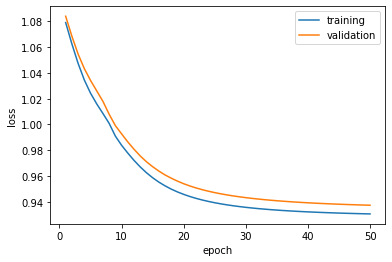

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### View the Learned Weights and Biases
The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:
* Layer 1: There are two input values going to ten output nodes, so there should be 10 x 2 weights and 10 bias values.
* Layer 2: There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
* Layer 3: There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values.

In [9]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[ 0.45085755  0.55521697]
 [ 0.46970654 -0.84104764]
 [ 0.12402982 -0.49943238]
 [ 0.01413935 -0.28021112]
 [ 0.51844996 -0.15568654]
 [ 0.32750416  0.18849647]
 [-0.32809594 -0.38218027]
 [ 0.1331784  -0.15668033]
 [-0.6203245   0.2546872 ]
 [-0.14468692  0.50291   ]]
fc1.bias 
 [-0.24176624 -0.7287162   0.3310246  -0.0737583   0.03070615  0.42906517
  0.21995378 -0.41981447 -0.10214746  0.4308273 ]
fc2.weight 
 [[ 0.190582    0.6416389  -0.17549267 -0.08031946  0.00561696 -0.20334718
  -0.2932468   0.15766017 -0.11892989 -0.7005421 ]
 [ 0.05892324  0.06760782  0.1671811   0.13972777 -0.15277655  0.03531554
  -0.20838773 -0.13560054 -0.0971216   0.02752838]
 [ 0.08505492  0.649911    0.04572394 -0.14917114 -0.09434517  0.32223344
  -0.20810147  0.3556093   0.0134514  -0.49667272]
 [ 0.17024584  0.8352898  -0.18098335  0.0173023   0.2268422  -0.09903176
  -0.20619154  0.33274323  0.09016505 -0.67443603]
 [-0.2486057  -0.03443047  0.21857658  0.06660044 -0.02778372 -0.2753

### Evaluate Model Performance
So, is the model any good? The raw accuracy reported from the validation data would seem to indicate that it predicts pretty well; but it's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performace of a classification model is to create a *confusion matrix* that shows a crosstab of correct and incorrect predictions for each class.

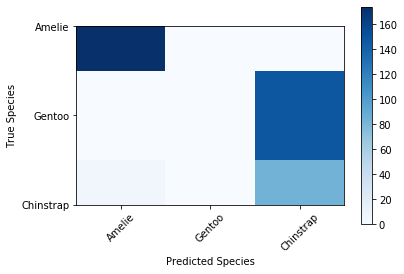

In [10]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("True Species")
plt.show()

The confusion matrix should show a strong diagonal line indicating that there are more correct than incorrect predictions for each class.

### Using the Model with New Data
Now that we have a model we believe is reasonably accurate, we can use it to predict the species of new iris observations:

In [11]:
# Save the model weights
model_file = '/penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
del model

# New data
x_new = [[50.4,15.3]]
print ('New sample: {}'.format(x_new))

# Create a new model class and load weights
model = PenguinNet()
model.load_state_dict(torch.load(model_file))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:',penguin_classes[predicted.item()])

New sample: [[50.4, 15.3]]
Prediction: Chinstrap
